# Lab5:  Unsupervised Learning 

Outline:
1. Preamble: unserializing data
2. Non-Negative Matrix Factorization 
3. Hierarchical Clustering

# Introduction

In this lab we will focus on unsupervised learning, a set of statistical tools intended for the setting in which we have only a set of features $X_{1},\ldots,X_{p}$ measured on $n$ observations. 

We are not interested in prediction, because we do not have an associated response variable $Y$ (as we did in Lab4). Rather, the goal is to discover interesting things about the measurements on $X_{1},\ldots,X_{p}$.

# 1. Preamble: unserializing data

`pickle` file is a python module for saving data objects into a file.

In [1]:
# Import modules
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess as sp
import pickle # to serialize/unserialize python data objects

import helper_basketball as h
import imp
imp.reload(h);

In [2]:
# This is our original data set:
allshots = pickle.load(open('allshots2016-17.pkl', 'rb'))
allmade = allshots
allmade[1:10]

,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,PlayerID
1,26,-160,205,1,1,203518
2,2,20,3,1,1,203518
3,26,-150,219,1,1,203518
4,26,-52,257,1,0,203518
5,27,145,232,1,0,203518
7,23,-230,46,1,0,203518
8,27,-178,208,1,0,203518
9,27,159,228,1,1,203518
10,3,4,33,1,0,203518


## Serialization

> In computer science, in the context of data storage, serialization is the process of translating data structures or object state into a format that can be stored (for example, in a file or memory buffer) or transmitted (for example, across a network connection link) and reconstructed later (possibly in a different computer environment).

In [3]:
## bin edge definitions in inches
xedges = (np.linspace(start=-25, stop=25, num=151, dtype=np.float)) * 12
yedges = (np.linspace(start= -4, stop=31, num=106, dtype=np.float)) * 12

## 2d histogram containers for binned counts and smoothed binned counts
all_counts = {}
all_smooth = {}

## data matrix: players (row) by vectorized 2-d court locations (column)
for i, one in enumerate(allmade.groupby('PlayerID')):
    
    ## what does this line do?
    pid, pdf = one
    
    ## h.bin_shots: what is this function doing?
    tmp1, xedges, yedges = h.bin_shots(pdf, bin_edges=(xedges, yedges), density=True, sigma=2)
    tmp2, xedges, yedges = h.bin_shots(pdf, bin_edges=(xedges, yedges), density=False)
    
    ## vectorize and store into dictionary
    # see: https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
    all_smooth[pid] = tmp1.reshape(-1)
    all_counts[pid] = tmp2.reshape(-1)

- Here we proceed to serialize the dictionary of smoothed patters (first part of Hw3). 
- In this case, the object `all_smooth` is a dictionary that consists of `len(all_smooth)` (362) arrays of length `15750`. 
- Each entry in `all_smooth` represents the smoothed frequency of shots along the bins generated in the code above for a given player.

In [4]:
pickle.dump(np.stack(all_smooth.values()).T, open('allpatterns2016-17.pkl', 'wb'))

## Unserialize smothed frequency values

In [5]:
X = pickle.load(open('allpatterns2016-17.pkl', 'rb'))

# 2. Non-negative Matrix Factorization (NMF) 

Non-negative matrix factorization was used on the smoothed shooting pattern data of around 360 players. The result was useful in
* Bases: Identifying modes of shooting style (number of modes was determined by `n_components` argument to `NMF` function)
* Coefficients: How each players shooting style could be expressed as a linear combination of these bases (matrix multiplication between the bases and coefficients achieve this)

Recall the following. Given some matrix $X$ is $p\times n$ matrix, NMF computes the following factorization:
$$ \min_{W,H} \| X - WH \|_F\\
\text{ subject to } W\geq 0,\ H\geq 0, $$
where $W$ is ${p\times r}$ matrix and $H$ is ${r\times n}$ matrix.

In [6]:
## Non-negative Matrix Factorization
def non_negative_marix_decomp(n_components,train_data):
    import sklearn.decomposition as skld
    model = skld.NMF(n_components=n_components, init='nndsvda', max_iter=500, random_state=0)
    W = model.fit_transform(train_data)
    H = model.components_
    nmf = (W,H)
    return(nmf)

In [7]:
r = 3
# X = np.stack(all_smooth.values()).T # Why did we transpose it?
W_3,H_3 = non_negative_marix_decomp(n_components = r,train_data = X)

# Re-constructing shooting pattern for *one* player

Below we re-construct the shooting pattern for a single player. By "reconstructing" we mean use the approximation $$\hat{X} = WH$$ obtained via NMF.

**Remark**: In hw3 you have to plot the shooting pattern reconstruction for *at least two players* and $r\in \{3,20\}$.

In [8]:
X3_hat = np.matmul(W_3,H_3) 

Text(0.5,1,'Estimated Shooting Pattern (r=3)')

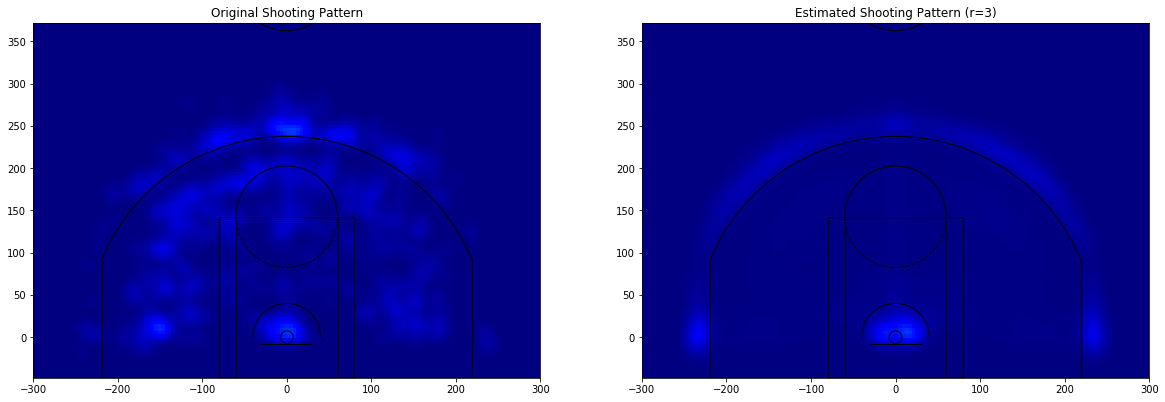

In [9]:
fig, ax = plt.subplots(1,2, figsize=(20,60))

# I took the first player appearing in first column 
# (you probably want to do more interesting players)
h.plot_shotchart(X[:,1], xedges, yedges, ax=ax[0]) 
h.plot_shotchart(X3_hat[:,1], xedges, yedges, ax=ax[1])
ax[0].set_title('Original Shooting Pattern')
ax[1].set_title('Estimated Shooting Pattern (r=3)')

We now compute the Frobenious norm between the actual and estimated shooting patterns for several values of number of bases, $r = 1,\ldots,10$.

In [10]:
# Frobenious norm
from numpy import linalg as LA # To compute Frobenious norm
LA.norm(X-np.matmul(W_3,H_3),'fro')

0.18669763284696192

In [11]:
from numpy import linalg as LA # To compute Frobenious norm
r_values = np.arange(10)+1
error_norm = []
for r in r_values:
    W,H = non_negative_marix_decomp(n_components = r,train_data = X)
    error_norm.append(LA.norm(X-np.matmul(W,H),'fro'))

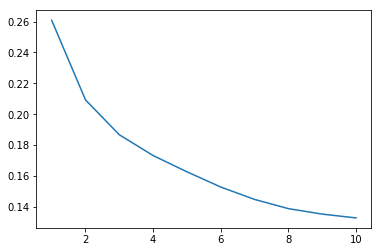

In [12]:
plt.plot(r_values,error_norm)

# Correlation matrix

In [13]:
# Example
A = np.array([[0.1, .32, .2, 0.4, 0.8], 
             [.23, .18, .56, .61, .12], 
             [.9, .3, .6, .5, .3],
             [.34, .75, .91, .19, .21]])
A.shape

(4, 5)

In [14]:
?np.corrcoef

In [15]:
Corr_A = np.corrcoef(A,rowvar=0)
Corr_A

array([[ 1.        , -0.03783885,  0.34905716,  0.14648975, -0.34945863],
       [-0.03783885,  1.        ,  0.67888519, -0.96102583, -0.12757741],
       [ 0.34905716,  0.67888519,  1.        , -0.45104803, -0.80429469],
       [ 0.14648975, -0.96102583, -0.45104803,  1.        , -0.15132323],
       [-0.34945863, -0.12757741, -0.80429469, -0.15132323,  1.        ]])

## Correlation matrix of frequency data

For computational purposes, let us consider only the first 100 columns of our information matrix $X$. We will then compute its correlation matrix and plot it as a heatmap using the `seaborn` package.

**Remark**: In hw3 you have to consider all 362 players. 

In [16]:
X_test = X[:,0:99].copy()
R = np.corrcoef(X_test,rowvar=0) # Transpose to compute correlation between colums

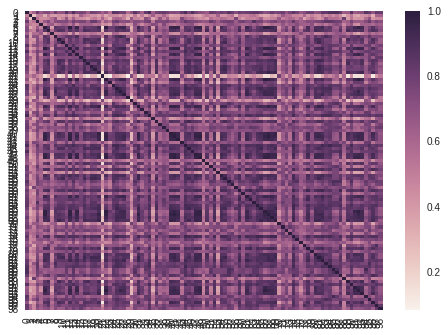

In [17]:
import seaborn as sns; sns.set()
ax = sns.heatmap(R)

# 3. Hierarchical Clustering


*Clustering* refers to a very broad set of techniques for finding subgroups, or clusters, in a data set. When we cluster the observations of a data set, we seek to partition them into distinct groups so that the observations within each group are quite similar to each other, while observations in different groups are quite different from each other. 

- Hierarchical Clustering: the number of groups or clusters need not to be specified in advanced (in contrast to $K$-means).
- Bottom-up or agglomerative clustering: Each observation is assumed to belong to its own cluster and they are sequentially fused based on a measure of dissimilartiy between clusters (also known as linkage). 
- The relationship among different clusters is represented graphically via a tree-like plot known as *dendogram*.

The hierarchical clustering dendrogram is obtained via an extremely simple algorithm:

Starting out at the bottom of the dendrogram, each of the $n$ observations is treated as its own cluster. The two clusters that are most similar to each other are then fused so that there now are $n - 1$ clusters. Next the two clusters that are most similar to each other are fused again, so that there now are $n - 2$ clusters. The algorithm proceeds in this fashion until all of the observations belong to one single cluster, and the dendrogram is complete.

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

> **Complete linkage**: Maximal intercluster dissimilarity. Compute all pairwise dissimilarities between the observations in cluster A and the observations in cluster B, and record the largest of these dissimilarities.

In [19]:
Z = linkage(X_test.T,method='complete',metric='correlation') # why did we transpose X.test?

## Plotting the dendogram

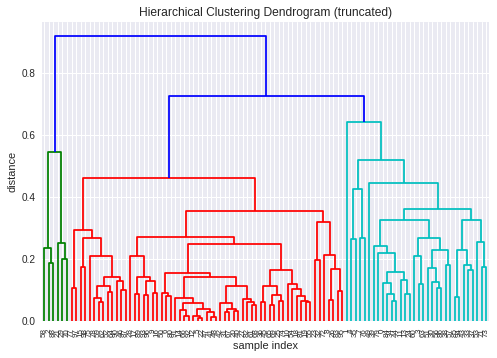

In [20]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

## Obtaining the cluster *id* for each player

In [21]:
from scipy.cluster.hierarchy import fcluster
no_max_clust = 10
cluster_id = fcluster(Z,no_max_clust,criterion='maxclust')
cluster_id

array([ 7, 10,  1,  7,  5,  4,  4,  6,  4,  4,  4,  7,  4,  7,  4,  3,  4,
        4,  4,  4,  4,  2,  4,  4,  7,  4,  4,  4,  4,  2,  7,  4,  4,  8,
        7,  5,  4,  8,  7,  7,  4,  4,  4,  8,  7,  4,  3,  4,  4,  9,  4,
        7,  3,  8,  4,  4,  7,  7,  1,  3,  7,  4,  3,  7,  3,  4,  4,  4,
        4,  4,  2,  8,  4,  8,  4,  3,  6,  3,  3,  7,  4,  4,  4,  4,  7,
        8,  7,  3,  1,  4,  3,  4,  4,  4,  8,  4,  4,  3,  3], dtype=int32)

In [22]:
np.sort(cluster_id)

array([ 1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  9, 10], dtype=int32)

In [23]:
np.argsort(cluster_id)

array([88,  2, 58, 70, 29, 21, 98, 90, 46, 97, 52, 78, 15, 87, 77, 62, 75,
       64, 59, 41, 42, 83, 82, 69, 68, 45, 67, 48, 66, 50, 81, 65, 80, 40,
       55, 61, 47, 54, 36, 74,  5,  6,  8,  9, 10, 93, 12, 92, 14, 16, 96,
       17, 19, 18, 31, 72, 89, 32, 20, 28, 95, 26, 25, 91, 23, 22, 27, 35,
        4, 76,  7, 84, 86, 79,  0, 38, 63, 60, 57, 56,  3, 51, 44, 39, 11,
       13, 24, 34, 30, 94, 71, 37, 73, 85, 43, 53, 33, 49,  1])

## Plot of correlation matrix in terms of cluster assignment

In [24]:
R_clust = np.corrcoef(X_test.T[np.argsort(cluster_id)])

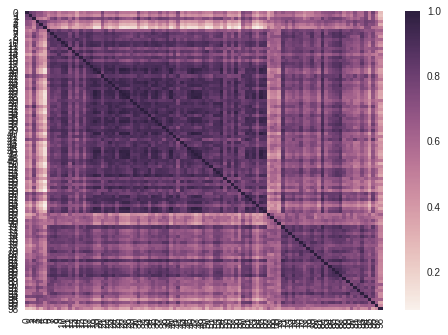

In [25]:
ax = sns.heatmap(R_clust)